# HOXA1 Knockdown: edgeR vs edgePython Side-by-Side Comparison

This notebook runs the **edgePython** differential expression pipeline on the HOXA1 knockdown dataset and compares results side-by-side with pre-computed **edgeR** outputs. The data are from [Trapnell et al. (2013)](https://doi.org/10.1038/nbt.2594) (GSE37704): 3 scrambled control vs 3 HOXA1 knockdown samples, with transcript-level quantification by kallisto.

This notebook reproduces the HOXA1-related panels from Figure 1 of the edgePython paper:

- **(a)** TMM normalization factors
- **(b)** Tagwise BCV
- **(c)** QL F-test log-fold-changes
- **(d)** QL posterior variances
- **(e)** Exact test p-values
- **(f)** QL F-test p-values
- **(g)** LRT TREAT p-values (pooled across 4 lfc thresholds)
- **(n)** DTU gene-level Simes p-values
- **(o)** DTU exon-level p-values
- **(p)** Scaled analysis QL p-values (with bootstrap overdispersion)

In [1]:
import sys, subprocess

IN_COLAB = 'google.colab' in sys.modules

try:
    import edgepython as ep
except ImportError:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'edgepython'])
    import edgepython as ep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams.update({
    'figure.dpi': 120, 'font.size': 10, 'axes.titlesize': 11,
    'axes.labelsize': 10, 'axes.spines.top': False, 'axes.spines.right': False,
})

BLUE = '#4878cf'

BASE_URL = 'https://raw.githubusercontent.com/pachterlab/edgePython/main/examples/hoxa1/data'

## 1. Load Data and R Results

In [2]:
# Count data and sample info
counts_df = pd.read_csv(f'{BASE_URL}/counts.tsv', sep='\t', index_col=0)
sample_info = pd.read_csv(f'{BASE_URL}/sample_info.tsv', sep='\t')

samples = counts_df.columns.tolist()
condition = sample_info['group'].values

# R results
r_norm = pd.read_csv(f'{BASE_URL}/R_norm_factors.csv')
r_disp = pd.read_csv(f'{BASE_URL}/R_dispersions.csv')
r_qlf = pd.read_csv(f'{BASE_URL}/R_qlf_all_results.csv', index_col=0)
r_exact = pd.read_csv(f'{BASE_URL}/R_exact_all_results.csv', index_col=0)
r_ql_fit = pd.read_csv(f'{BASE_URL}/R_ql_fit_details.csv')

# TREAT results (4 thresholds)
r_treat_lfc10 = pd.read_csv(f'{BASE_URL}/R_treat_lrt_hoxa1_lfc10.csv', index_col=0)
r_treat_lfc12 = pd.read_csv(f'{BASE_URL}/R_treat_lrt_hoxa1_lfc12.csv', index_col=0)
r_treat_lfc15 = pd.read_csv(f'{BASE_URL}/R_treat_lrt_hoxa1_lfc15.csv', index_col=0)
r_treat_worst = pd.read_csv(f'{BASE_URL}/R_treat_lrt_hoxa1_worst.csv', index_col=0)

# DTU results
r_dtu_gene = pd.read_csv(f'{BASE_URL}/R_dtu_gene_results.csv')
r_dtu_exon = pd.read_csv(f'{BASE_URL}/R_dtu_exon_results.csv')

# Scaled analysis results
r_scaled_qlf = pd.read_csv(f'{BASE_URL}/R_scaled_qlf_all_results.csv', index_col=0)
r_scaled_disp = pd.read_csv(f'{BASE_URL}/R_scaled_dispersions.csv')

# Transcript-to-gene mapping (for DTU)
t2g = pd.read_csv(f'{BASE_URL}/t2g_mapping.csv')

print(f'Count matrix: {counts_df.shape[0]:,} transcripts x {counts_df.shape[1]} samples')
print(f'R dispersions: {r_disp.shape[0]:,} transcripts (after filtering)')
print(f'R DTU genes: {r_dtu_gene.shape[0]:,}')
print(f'R scaled QLF: {r_scaled_qlf.shape[0]:,} transcripts')

Count matrix: 207,175 transcripts x 6 samples
R dispersions: 44,514 transcripts (after filtering)
R DTU genes: 9,697
R scaled QLF: 44,811 transcripts


## 2. Run edgePython Standard Pipeline

In [3]:
# Standard pipeline: filter + TMM + estimateDisp + QL fit + exact test
counts = counts_df.values.astype(np.float64)
counts = np.round(counts)
target_ids = counts_df.index.values
group = np.array([0, 0, 0, 1, 1, 1])  # 0=scramble, 1=HOXA1KD

y = ep.make_dgelist(counts, group=group)
print(f'Transcripts before filtering: {counts.shape[0]:,}')

keep = ep.filter_by_expr(y, group=group)
print(f'Transcripts after filtering: {np.sum(keep):,}')

counts_filt = counts[keep]
target_ids_filt = target_ids[keep]
y = ep.make_dgelist(counts_filt, group=group)
y = ep.calc_norm_factors(y)

design = np.column_stack([np.ones(6), group])
y = ep.estimate_disp(y, design)
print(f'Common dispersion: {y["common.dispersion"]:.6f}')

# QL F-test
fit = ep.glm_ql_fit(y, design)
qlf = ep.glm_ql_ftest(fit, coef=1)  # coef=1 (0-indexed) = HOXA1KD
ngenes = len(target_ids_filt)
py_qlf_all = ep.top_tags(qlf, n=ngenes)

# Exact test
et = ep.exact_test(y, pair=[0, 1])
py_et_all = ep.top_tags(et, n=ngenes)

print('Standard pipeline complete.')

Transcripts before filtering: 207,175
Transcripts after filtering: 44,514


Common dispersion: 0.342189


Standard pipeline complete.


## 3. Run edgePython LRT TREAT Pipeline

In [4]:
# LRT fit for TREAT
fit_lrt = ep.glm_fit(y, design)

# TREAT at 4 thresholds
import math

py_treat_lfc10 = ep.glm_treat(fit_lrt, coef=1, lfc=1.0)
py_treat_lfc12 = ep.glm_treat(fit_lrt, coef=1, lfc=math.log2(1.2))
py_treat_lfc15 = ep.glm_treat(fit_lrt, coef=1, lfc=math.log2(1.5))
py_treat_worst = ep.glm_treat(fit_lrt, coef=1, lfc=math.log2(1.5), null='worst.case')

py_tt_lfc10 = ep.top_tags(py_treat_lfc10, n=ngenes, sort_by='none')['table']
py_tt_lfc12 = ep.top_tags(py_treat_lfc12, n=ngenes, sort_by='none')['table']
py_tt_lfc15 = ep.top_tags(py_treat_lfc15, n=ngenes, sort_by='none')['table']
py_tt_worst = ep.top_tags(py_treat_worst, n=ngenes, sort_by='none')['table']

# Map indices to transcript IDs
for tt in [py_tt_lfc10, py_tt_lfc12, py_tt_lfc15, py_tt_worst]:
    tt.index = target_ids_filt[tt.index.values]

print('LRT TREAT pipeline complete.')

LRT TREAT pipeline complete.


## 4. Run edgePython DTU & Scaled Analysis Pipelines

Both pipelines use kallisto H5 files with bootstrap samples. The DTU analysis requires a transcript-to-gene mapping and removes unmapped transcripts. The scaled analysis keeps all transcripts (matching the R pipeline).

In [5]:
# Download kallisto H5 quantifications with bootstraps from CaltechDATA
import os, tempfile, zipfile, urllib.request

QUANT_URL = 'https://data.caltech.edu/records/3scww-j5644/files/GSE37704_kallisto_quantifications.zip?download=1'
quant_dir = tempfile.mkdtemp()
zip_path = os.path.join(quant_dir, 'quant.zip')
print('Downloading kallisto quantifications (411 MB)...', flush=True)
urllib.request.urlretrieve(QUANT_URL, zip_path)
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(quant_dir)
os.remove(zip_path)
quant_dir = os.path.join(quant_dir, 'quant')
print('Download complete.')

sample_names = ['SRR493366', 'SRR493367', 'SRR493368',
                'SRR493369', 'SRR493370', 'SRR493371']
paths = [f'{quant_dir}/{s}' for s in sample_names]

y_h5 = ep.read_data(paths, source='kallisto', format='h5',
                     labels=sample_names, group=group, verbose=True)

overdisp = y_h5['genes']['Overdispersion'].values
print(f'Overdispersion range: {overdisp.min():.4f} - {overdisp.max():.4f}')
print(f'Overdispersion median: {np.median(overdisp):.4f}')

# ── Scaled analysis (all transcripts, matching R) ──
keep_sc = ep.filter_by_expr(y_h5, group=group)
counts_sc = y_h5['counts'][keep_sc]
genes_sc = y_h5['genes'].iloc[keep_sc].copy().reset_index(drop=True)
tx_ids_sc = y_h5['genes'].index[keep_sc]
genes_sc.index = tx_ids_sc

y_sc_filt = ep.make_dgelist(counts_sc, group=group, genes=genes_sc)
y_sc_filt['samples'].index = sample_names
y_sc_filt = ep.calc_norm_factors(y_sc_filt)
y_sc_filt = ep.estimate_disp(y_sc_filt, design, robust=True)
print(f'Scaled: {np.sum(keep_sc):,} transcripts, common disp={y_sc_filt["common.dispersion"]:.6f}')

fit_sc = ep.glm_ql_fit(y_sc_filt, design, robust=True)
qlf_sc = ep.glm_ql_ftest(fit_sc, coef=1)
n_sc = counts_sc.shape[0]
py_scaled_all = ep.top_tags(qlf_sc, n=n_sc)
py_scaled_tab = py_scaled_all['table'].copy()
py_scaled_tab.index = tx_ids_sc.values[py_scaled_tab.index.values]
print(f'Scaled analysis complete: {n_sc:,} transcripts')

# ── DTU analysis (remove unmapped, matching R DTU) ──
t2g_dict = dict(zip(t2g['target_id'], t2g['gene_id']))
tx_names_h5 = y_h5['genes'].index.values
gene_ids_h5 = np.array([t2g_dict.get(tx, None) for tx in tx_names_h5])
y_h5['genes']['GeneID'] = gene_ids_h5

keep_mapped = np.array([g is not None for g in gene_ids_h5])
counts_dtu = y_h5['counts'][keep_mapped]
genes_dtu = y_h5['genes'].iloc[keep_mapped].copy().reset_index(drop=True)
genes_dtu.index = tx_names_h5[keep_mapped]
print(f'DTU: {np.sum(keep_mapped):,} mapped transcripts')

y_dtu = ep.make_dgelist(counts_dtu, group=group, genes=genes_dtu)
y_dtu['samples'].index = sample_names
keep_dtu = ep.filter_by_expr(y_dtu, group=group)
counts_dtu_filt = y_dtu['counts'][keep_dtu]
genes_dtu_filt = y_dtu['genes'].iloc[keep_dtu].copy().reset_index(drop=True)
genes_dtu_filt.index = y_dtu['genes'].index[keep_dtu]

y_dtu_filt = ep.make_dgelist(counts_dtu_filt, group=group, genes=genes_dtu_filt)
y_dtu_filt['samples'].index = sample_names
y_dtu_filt = ep.calc_norm_factors(y_dtu_filt)
y_dtu_filt = ep.estimate_disp(y_dtu_filt, design, robust=True)
print(f'DTU after filtering: {np.sum(keep_dtu):,} transcripts, common disp={y_dtu_filt["common.dispersion"]:.6f}')

fit_dtu = ep.glm_ql_fit(y_dtu_filt, design, robust=True)
sp = ep.diff_splice(fit_dtu, coef=1, geneid='GeneID', verbose=True)

from statsmodels.stats.multitest import multipletests

gene_tab = pd.DataFrame({
    'GeneID': sp['gene.genes'][sp['genecolname']].values,
    'NExons': sp['gene.genes']['NExons'].values,
    'gene.F': sp['gene.F'].ravel(),
    'gene.df.test': sp['gene.df.test'].ravel(),
    'gene.p.value': sp['gene.p.value'],
    'gene.Simes.p.value': sp['gene.Simes.p.value'],
})
_, gene_fdr, _, _ = multipletests(gene_tab['gene.p.value'], method='fdr_bh')
_, simes_fdr, _, _ = multipletests(gene_tab['gene.Simes.p.value'], method='fdr_bh')
gene_tab['FDR'] = gene_fdr
gene_tab['Simes.FDR'] = simes_fdr

exon_tab = pd.DataFrame({
    'GeneID': sp['genes'][sp['genecolname']].values,
    'logFC': sp['coefficients'],
    'exon.F': sp['exon.F'],
    'exon.df.test': sp['exon.df.test'],
    'exon.p.value': sp['exon.p.value'],
})

print(f'DTU gene-level: {len(gene_tab):,} genes, exon-level: {len(exon_tab):,} exons')

Download complete.
Reading SRR493366, 207175 transcripts, 100 bootstraps


Reading SRR493367, 207175 transcripts, 100 bootstraps


Reading SRR493368, 207175 transcripts, 100 bootstraps


Reading SRR493369, 207175 transcripts, 100 bootstraps


Reading SRR493370, 207175 transcripts, 100 bootstraps


Reading SRR493371, 207175 transcripts, 100 bootstraps


Overdispersion range: 1.0000 - 380.7756
Overdispersion median: 2.0344


Scaled: 44,811 transcripts, common disp=0.342887


Scaled analysis complete: 44,811 transcripts
DTU: 207,175 mapped transcripts


DTU after filtering: 44,811 transcripts, common disp=0.342887


Total number of exons:  44811
Total number of genes:  13550
Number of genes with 1 exon:  3853
Mean number of exons in a gene:  3
Max number of exons in a gene:  29
DTU gene-level: 9,697 genes, exon-level: 40,958 exons


In [6]:
def scatter_compare(ax, x, y, title, xlabel='edgeR', ylabel='edgePython',
                    s=4, alpha=0.4):
    """Plot R vs Python scatter with identity line."""
    ax.scatter(x, y, c=BLUE, s=s, alpha=alpha, edgecolors='none', rasterized=True)
    mn = min(x.min(), y.min())
    mx = max(x.max(), y.max())
    margin = (mx - mn) * 0.05
    ax.plot([mn - margin, mx + margin], [mn - margin, mx + margin],
            'k-', lw=0.5, alpha=0.5)
    ax.set_xlim(mn - margin, mx + margin)
    ax.set_ylim(mn - margin, mx + margin)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.tick_params(labelsize=7)

## 5. Panel (a): TMM Normalization Factors

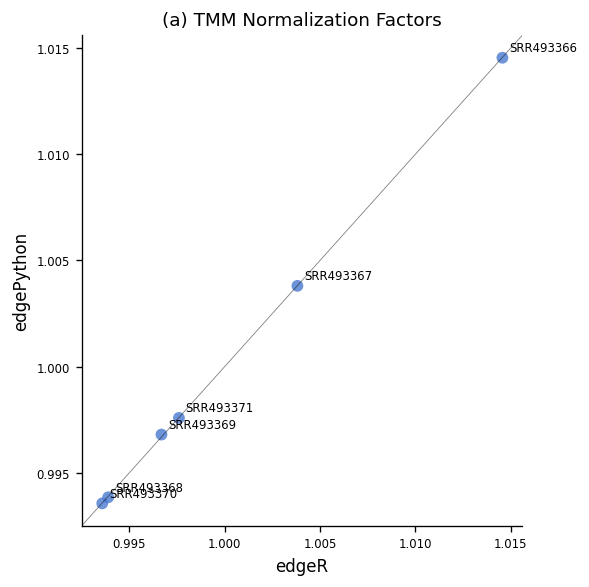

Max absolute difference: 1.146120e-04


In [7]:
r_nf = r_norm['norm.factors'].values
py_nf = y['samples']['norm.factors'].values

fig, ax = plt.subplots(figsize=(5, 5))
scatter_compare(ax, r_nf, py_nf, '(a) TMM Normalization Factors', s=50, alpha=0.8)
for i, s in enumerate(samples):
    ax.annotate(s, (r_nf[i], py_nf[i]), fontsize=7, xytext=(4, 4),
                textcoords='offset points')
plt.tight_layout()
plt.show()

print(f'Max absolute difference: {np.max(np.abs(r_nf - py_nf)):.6e}')

## 6. Panel (b): Tagwise BCV

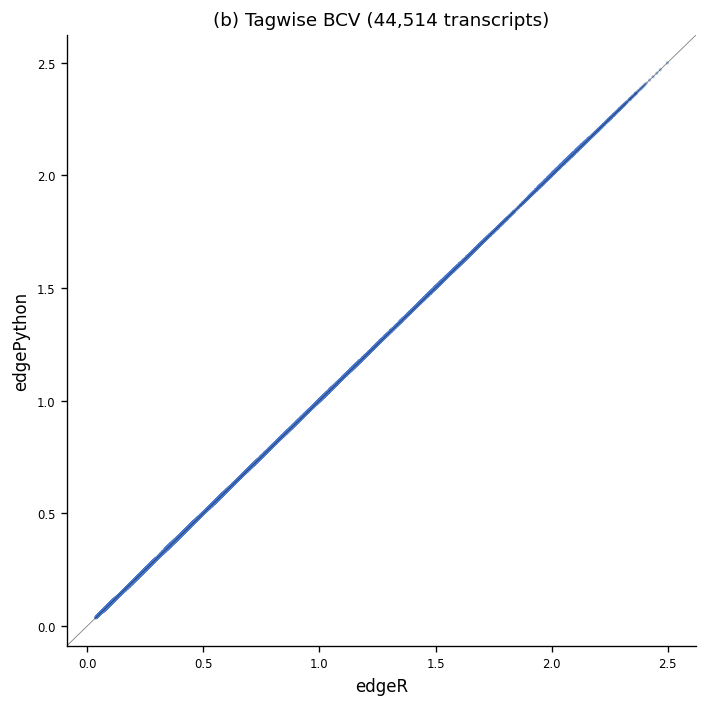

Pearson r: 0.99999761


In [8]:
# Align R and Python tagwise dispersions by transcript ID
r_disp_idx = r_disp.set_index('transcript')
py_tagwise = pd.Series(y['tagwise.dispersion'], index=target_ids_filt)
common = r_disp_idx.index.intersection(py_tagwise.index)

r_bcv = np.sqrt(r_disp_idx.loc[common, 'tagwise.dispersion'].values)
py_bcv = np.sqrt(py_tagwise.loc[common].values)

fig, ax = plt.subplots(figsize=(6, 6))
scatter_compare(ax, r_bcv, py_bcv, f'(b) Tagwise BCV ({len(common):,} transcripts)')
plt.tight_layout()
plt.show()

corr_bcv = np.corrcoef(r_bcv, py_bcv)[0, 1]
print(f'Pearson r: {corr_bcv:.8f}')

## 7. Panel (c): QL F-test Log-Fold-Changes

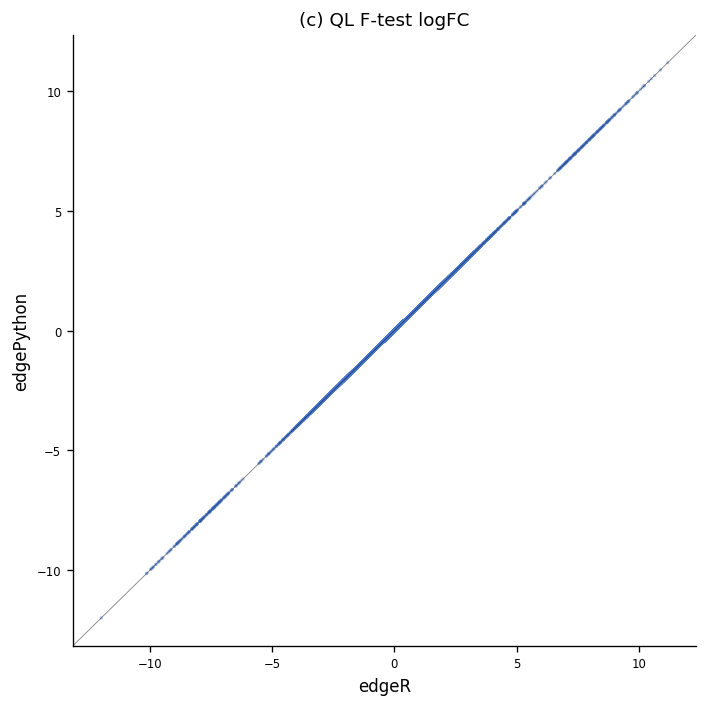

Pearson r: 0.99999998
Max |diff|: 2.63e-03


In [9]:
# Map Python QL results to transcript IDs
py_qlf_tab = py_qlf_all['table'].copy()
py_qlf_tab.index = target_ids_filt[py_qlf_tab.index.values]

r_qlf.index = r_qlf.index.astype(str)
py_qlf_tab.index = py_qlf_tab.index.astype(str)
common_ql = r_qlf.index.intersection(py_qlf_tab.index)

r_lfc = r_qlf.loc[common_ql, 'logFC'].values
py_lfc = py_qlf_tab.loc[common_ql, 'logFC'].values

fig, ax = plt.subplots(figsize=(6, 6))
scatter_compare(ax, r_lfc, py_lfc, '(c) QL F-test logFC')
plt.tight_layout()
plt.show()

corr_lfc = np.corrcoef(r_lfc, py_lfc)[0, 1]
print(f'Pearson r: {corr_lfc:.8f}')
print(f'Max |diff|: {np.max(np.abs(r_lfc - py_lfc)):.2e}')

## 8. Panel (d): QL Posterior Variances

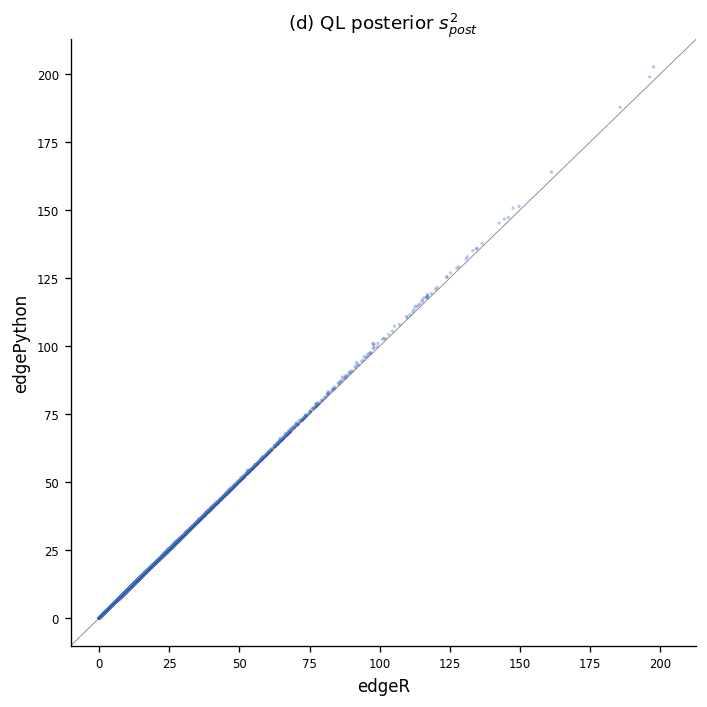

Pearson r: 0.99997855


In [10]:
r_fit_idx = r_ql_fit.set_index('transcript')
py_s2post = pd.Series(fit['s2.post'], index=target_ids_filt)
common_fit = r_fit_idx.index.intersection(py_s2post.index)

r_s2 = r_fit_idx.loc[common_fit, 's2.post'].values
py_s2 = py_s2post.loc[common_fit].values

fig, ax = plt.subplots(figsize=(6, 6))
scatter_compare(ax, r_s2, py_s2, r'(d) QL posterior $s^2_{post}$')
plt.tight_layout()
plt.show()

corr_s2 = np.corrcoef(r_s2, py_s2)[0, 1]
print(f'Pearson r: {corr_s2:.8f}')

## 9. Panel (e): Exact Test P-values

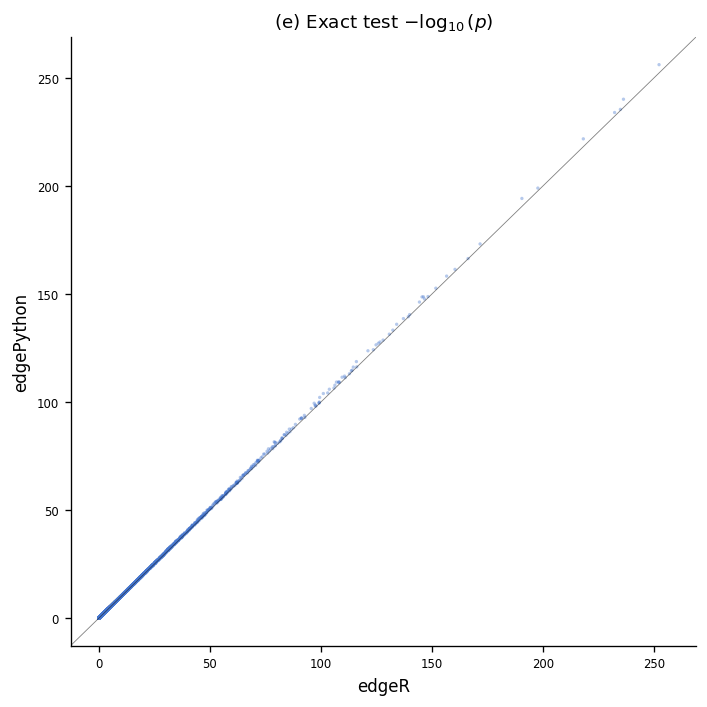

Pearson r: 0.99997260


In [11]:
py_et_tab = py_et_all['table'].copy()
py_et_tab.index = target_ids_filt[py_et_tab.index.values]

r_exact.index = r_exact.index.astype(str)
py_et_tab.index = py_et_tab.index.astype(str)
common_et = r_exact.index.intersection(py_et_tab.index)

r_p_et = r_exact.loc[common_et, 'PValue'].values
py_p_et = py_et_tab.loc[common_et, 'PValue'].values
mask_et = (r_p_et > 0) & (py_p_et > 0)

r_lp_et = -np.log10(r_p_et[mask_et])
py_lp_et = -np.log10(py_p_et[mask_et])

fig, ax = plt.subplots(figsize=(6, 6))
scatter_compare(ax, r_lp_et, py_lp_et, r'(e) Exact test $-\log_{10}(p)$')
plt.tight_layout()
plt.show()

corr_et = np.corrcoef(r_lp_et, py_lp_et)[0, 1]
print(f'Pearson r: {corr_et:.8f}')

## 10. Panel (f): QL F-test P-values

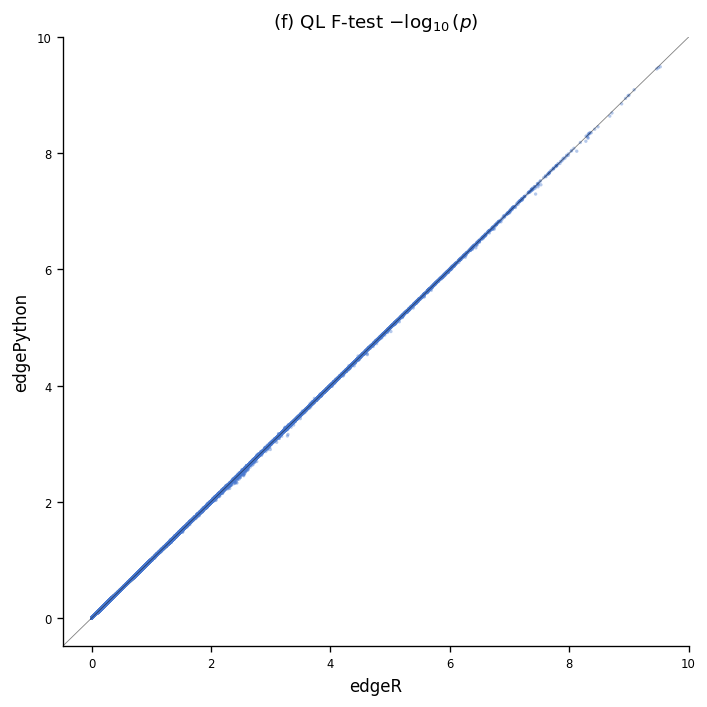

Pearson r: 0.99999274


In [12]:
r_p_ql = r_qlf.loc[common_ql, 'PValue'].values
py_p_ql = py_qlf_tab.loc[common_ql, 'PValue'].values
mask_ql = (r_p_ql > 0) & (py_p_ql > 0)

r_lp_ql = -np.log10(r_p_ql[mask_ql])
py_lp_ql = -np.log10(py_p_ql[mask_ql])

fig, ax = plt.subplots(figsize=(6, 6))
scatter_compare(ax, r_lp_ql, py_lp_ql, r'(f) QL F-test $-\log_{10}(p)$')
plt.tight_layout()
plt.show()

corr_ql = np.corrcoef(r_lp_ql, py_lp_ql)[0, 1]
print(f'Pearson r: {corr_ql:.8f}')

## 11. Panel (g): LRT TREAT P-values (Pooled)

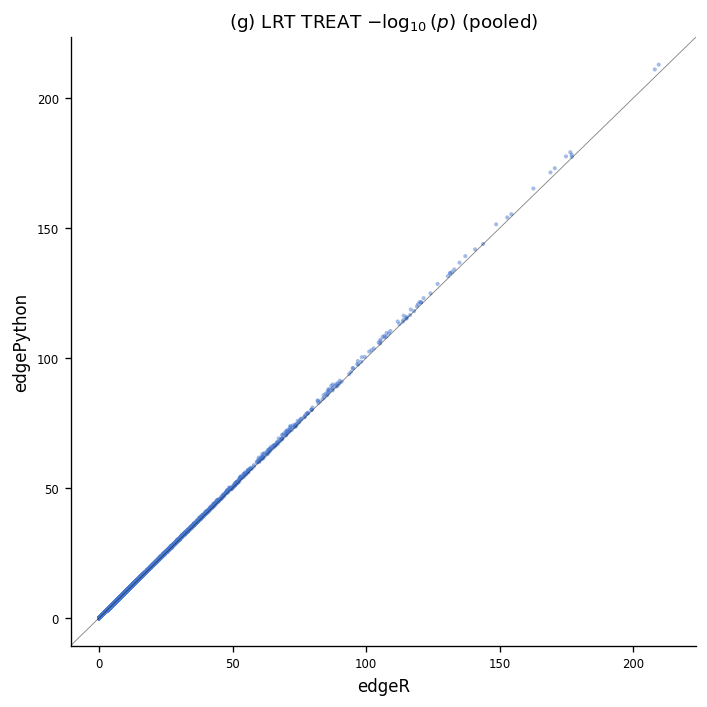

Points: 178,056
Pearson r: 0.99997375


In [13]:
# Pool p-values across 4 LRT TREAT conditions
r_treat_all = [r_treat_lfc10, r_treat_lfc12, r_treat_lfc15, r_treat_worst]
py_treat_all = [py_tt_lfc10, py_tt_lfc12, py_tt_lfc15, py_tt_worst]
labels = ['lfc=1.0', 'lfc=log2(1.2)', 'lfc=log2(1.5)', 'worst.case']

r_pvals_pooled, py_pvals_pooled = [], []
for r_df, py_df in zip(r_treat_all, py_treat_all):
    r_df.index = r_df.index.astype(str)
    py_df.index = py_df.index.astype(str)
    common_tr = r_df.index.intersection(py_df.index)
    r_pvals_pooled.extend(r_df.loc[common_tr, 'PValue'].values)
    py_pvals_pooled.extend(py_df.loc[common_tr, 'PValue'].values)

r_pvals_pooled = np.array(r_pvals_pooled)
py_pvals_pooled = np.array(py_pvals_pooled)
mask_tr = (r_pvals_pooled > 0) & (py_pvals_pooled > 0)

r_lp_tr = -np.log10(r_pvals_pooled[mask_tr])
py_lp_tr = -np.log10(py_pvals_pooled[mask_tr])

fig, ax = plt.subplots(figsize=(6, 6))
scatter_compare(ax, r_lp_tr, py_lp_tr,
                r'(g) LRT TREAT $-\log_{10}(p)$ (pooled)',
                s=6, alpha=0.5)
plt.tight_layout()
plt.show()

corr_treat = np.corrcoef(r_lp_tr, py_lp_tr)[0, 1]
print(f'Points: {np.sum(mask_tr):,}')
print(f'Pearson r: {corr_treat:.8f}')

## 12. Panel (n): DTU Gene-Level Simes P-values

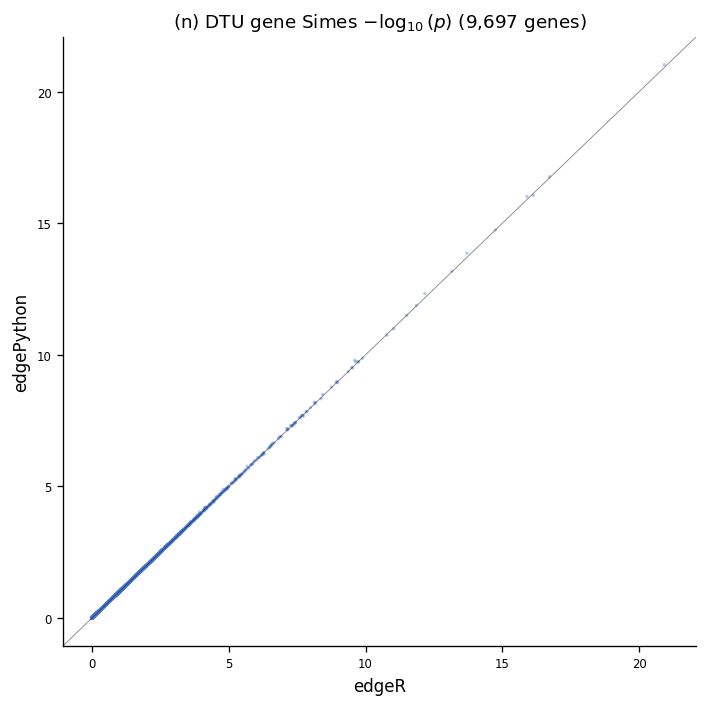

Pearson r: 0.99998289


In [14]:
# Align R and Python DTU gene-level results by GeneID
r_dtu_g = r_dtu_gene.set_index('GeneID')
py_dtu_g = gene_tab.set_index('GeneID')

common_dtu = r_dtu_g.index.intersection(py_dtu_g.index)
r_simes = r_dtu_g.loc[common_dtu, 'gene.Simes.p.value'].values
py_simes = py_dtu_g.loc[common_dtu, 'gene.Simes.p.value'].values
mask_dtu = (r_simes > 0) & (py_simes > 0)

r_lp_dtu = -np.log10(r_simes[mask_dtu])
py_lp_dtu = -np.log10(py_simes[mask_dtu])

fig, ax = plt.subplots(figsize=(6, 6))
scatter_compare(ax, r_lp_dtu, py_lp_dtu,
                f'(n) DTU gene Simes $-\\log_{{10}}(p)$ ({len(common_dtu):,} genes)')
plt.tight_layout()
plt.show()

corr_dtu_gene = np.corrcoef(r_lp_dtu, py_lp_dtu)[0, 1]
print(f'Pearson r: {corr_dtu_gene:.8f}')

## 13. Panel (o): DTU Exon-Level P-values

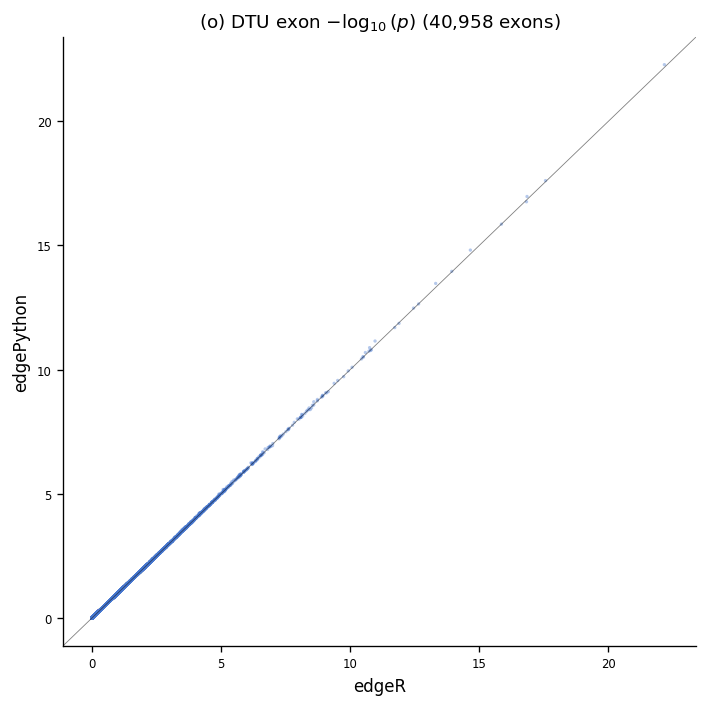

Pearson r: 0.99998648


In [15]:
# Exon-level p-values (aligned by position, same gene order)
r_exon_p = r_dtu_exon['exon.p.value'].values
py_exon_p = exon_tab['exon.p.value'].values

n_exon = min(len(r_exon_p), len(py_exon_p))
r_exon_p = r_exon_p[:n_exon]
py_exon_p = py_exon_p[:n_exon]

mask_exon = (r_exon_p > 0) & (py_exon_p > 0)
r_lp_exon = -np.log10(r_exon_p[mask_exon])
py_lp_exon = -np.log10(py_exon_p[mask_exon])

fig, ax = plt.subplots(figsize=(6, 6))
scatter_compare(ax, r_lp_exon, py_lp_exon,
                f'(o) DTU exon $-\\log_{{10}}(p)$ ({np.sum(mask_exon):,} exons)')
plt.tight_layout()
plt.show()

corr_dtu_exon = np.corrcoef(r_lp_exon, py_lp_exon)[0, 1]
print(f'Pearson r: {corr_dtu_exon:.8f}')

## 14. Panel (p): Scaled Analysis QL P-values

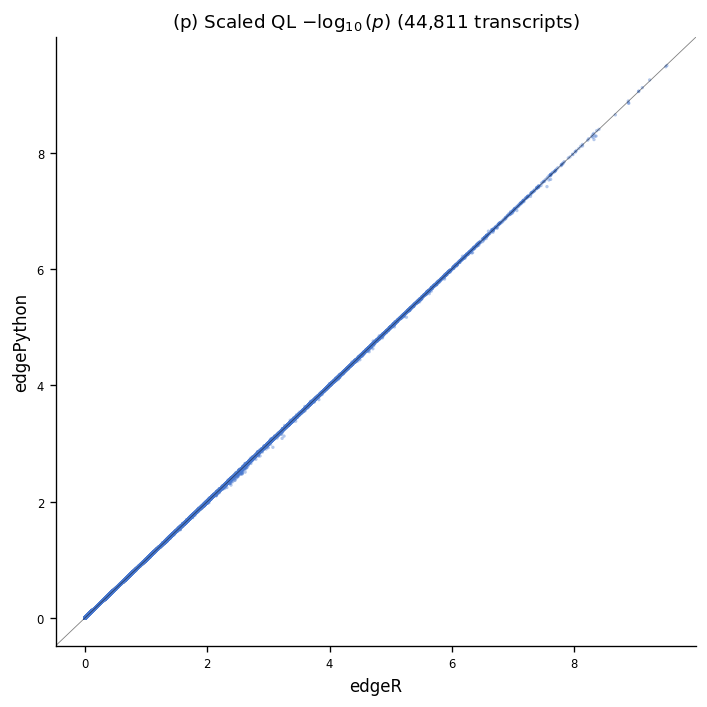

Pearson r: 0.99999207


In [16]:
r_scaled_qlf.index = r_scaled_qlf.index.astype(str)
py_scaled_tab.index = py_scaled_tab.index.astype(str)
common_sc = r_scaled_qlf.index.intersection(py_scaled_tab.index)

r_p_sc = r_scaled_qlf.loc[common_sc, 'PValue'].values
py_p_sc = py_scaled_tab.loc[common_sc, 'PValue'].values
mask_sc = (r_p_sc > 0) & (py_p_sc > 0)

r_lp_sc = -np.log10(r_p_sc[mask_sc])
py_lp_sc = -np.log10(py_p_sc[mask_sc])

fig, ax = plt.subplots(figsize=(6, 6))
scatter_compare(ax, r_lp_sc, py_lp_sc,
                f'(p) Scaled QL $-\\log_{{10}}(p)$ ({len(common_sc):,} transcripts)')
plt.tight_layout()
plt.show()

corr_scaled = np.corrcoef(r_lp_sc, py_lp_sc)[0, 1]
print(f'Pearson r: {corr_scaled:.8f}')

---
## 15. Combined Figure

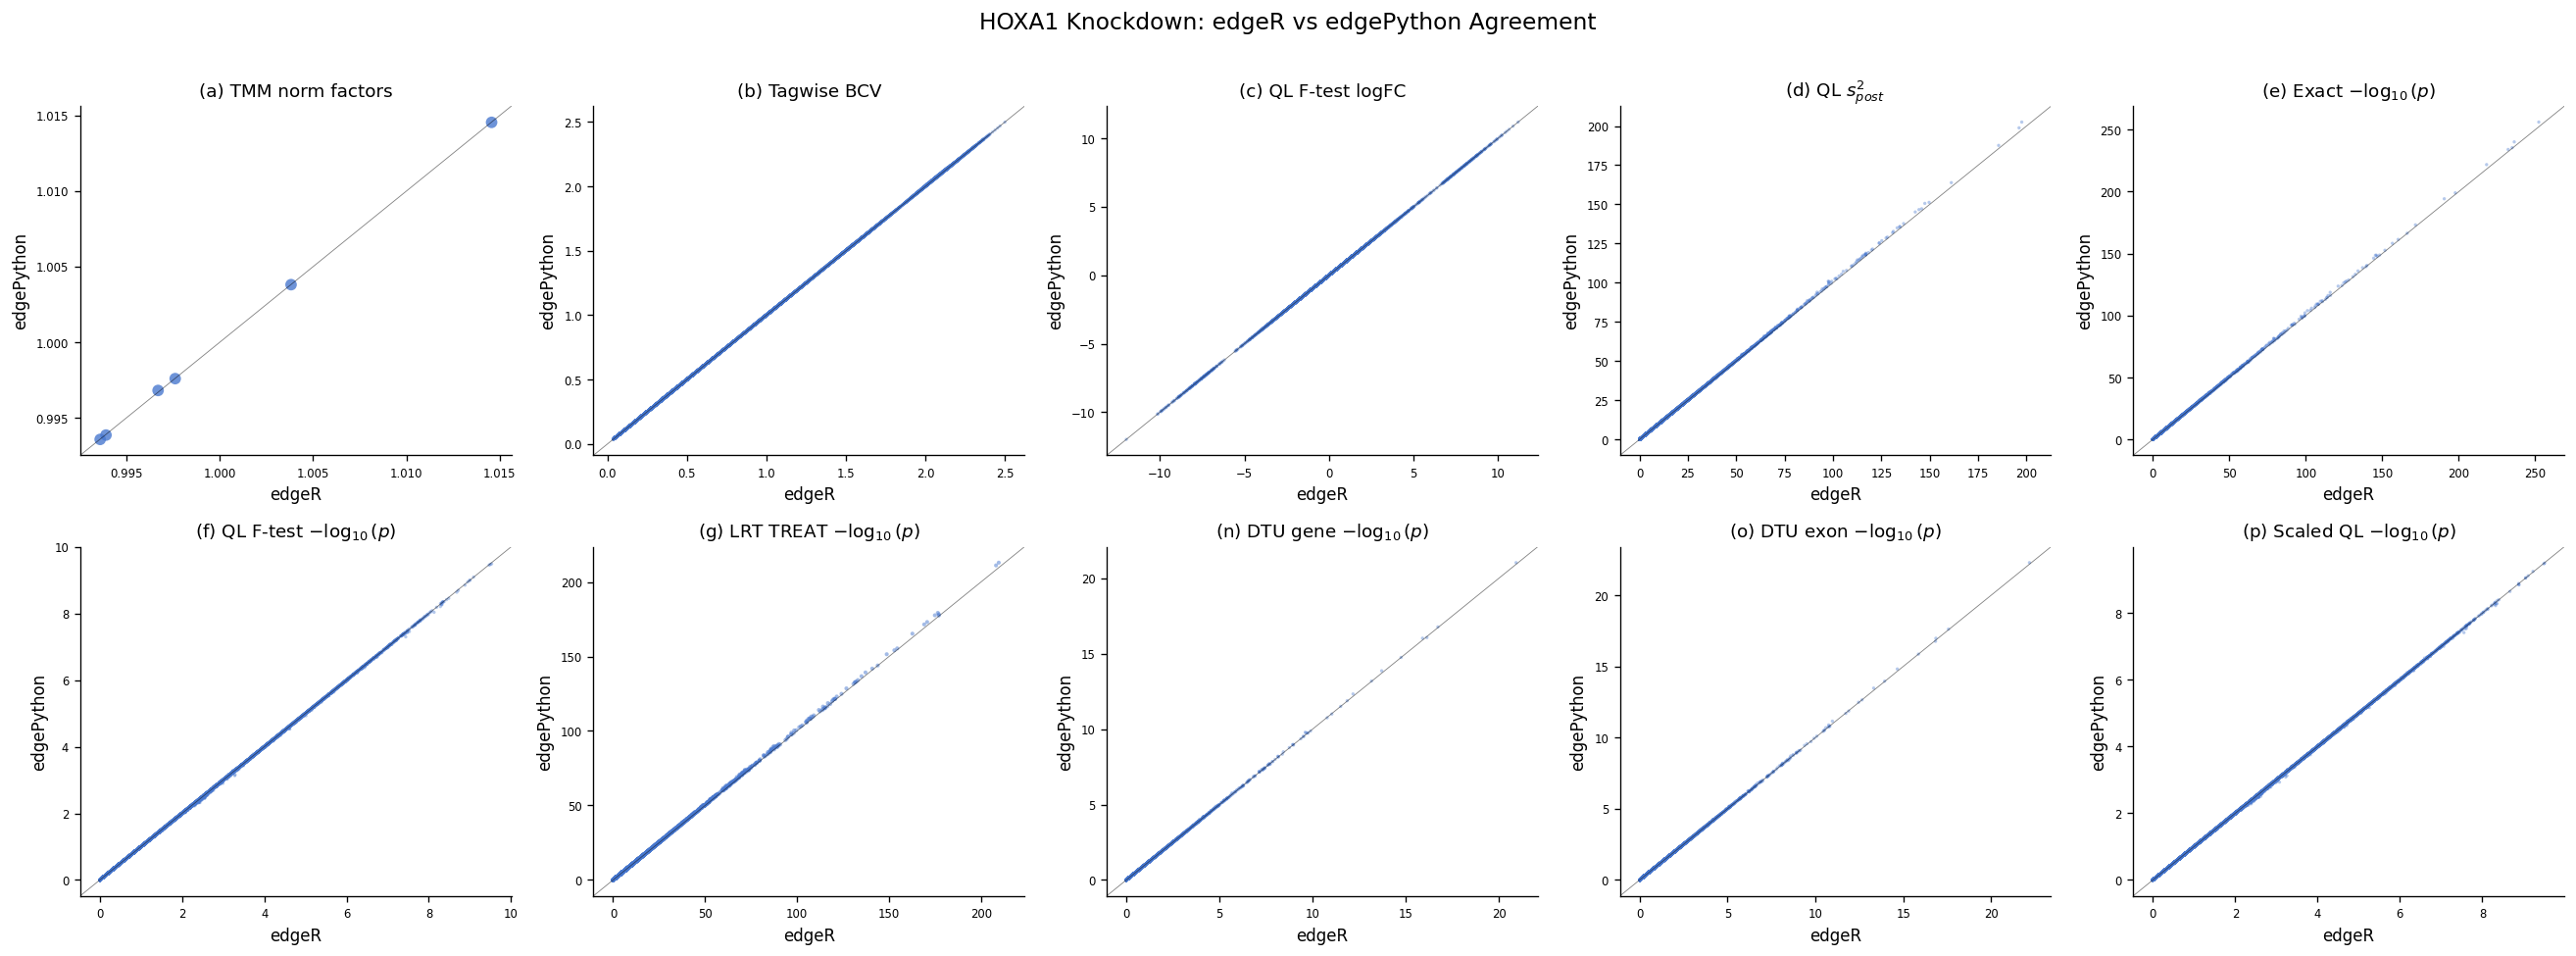

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(22, 8))

# Row 1: (a)-(e)
scatter_compare(axes[0, 0], r_nf, py_nf, '(a) TMM norm factors', s=50, alpha=0.8)
scatter_compare(axes[0, 1], r_bcv, py_bcv, '(b) Tagwise BCV')
scatter_compare(axes[0, 2], r_lfc, py_lfc, '(c) QL F-test logFC')
scatter_compare(axes[0, 3], r_s2, py_s2, r'(d) QL $s^2_{post}$')
scatter_compare(axes[0, 4], r_lp_et, py_lp_et, r'(e) Exact $-\log_{10}(p)$')

# Row 2: (f)-(g), (n)-(o), (p)
scatter_compare(axes[1, 0], r_lp_ql, py_lp_ql, r'(f) QL F-test $-\log_{10}(p)$')
scatter_compare(axes[1, 1], r_lp_tr, py_lp_tr, r'(g) LRT TREAT $-\log_{10}(p)$', s=6, alpha=0.5)
scatter_compare(axes[1, 2], r_lp_dtu, py_lp_dtu, r'(n) DTU gene $-\log_{10}(p)$')
scatter_compare(axes[1, 3], r_lp_exon, py_lp_exon, r'(o) DTU exon $-\log_{10}(p)$')
scatter_compare(axes[1, 4], r_lp_sc, py_lp_sc, r'(p) Scaled QL $-\log_{10}(p)$')

fig.suptitle('HOXA1 Knockdown: edgeR vs edgePython Agreement', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 16. Summary Statistics

In [18]:
summary = pd.DataFrame({
    'Panel': ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(n)', '(o)', '(p)'],
    'Metric': [
        'TMM norm factors (max |diff|)',
        'Tagwise BCV (r)',
        'QL F-test logFC (r)',
        'QL posterior s2.post (r)',
        'Exact test -log10(p) (r)',
        'QL F-test -log10(p) (r)',
        'LRT TREAT -log10(p) pooled (r)',
        'DTU gene Simes -log10(p) (r)',
        'DTU exon -log10(p) (r)',
        'Scaled QL -log10(p) (r)',
    ],
    'Value': [
        f'{np.max(np.abs(r_nf - py_nf)):.2e}',
        f'{corr_bcv:.8f}',
        f'{corr_lfc:.8f}',
        f'{corr_s2:.8f}',
        f'{corr_et:.8f}',
        f'{corr_ql:.8f}',
        f'{corr_treat:.8f}',
        f'{corr_dtu_gene:.8f}',
        f'{corr_dtu_exon:.8f}',
        f'{corr_scaled:.8f}',
    ]
})
summary

,Panel,Metric,Value
0,(a),TMM norm factors (max |diff|),1.15e-04
1,(b),Tagwise BCV (r),0.99999761
2,(c),QL F-test logFC (r),0.99999998
3,(d),QL posterior s2.post (r),0.99997855
4,(e),Exact test -log10(p) (r),0.99997260
5,(f),QL F-test -log10(p) (r),0.99999274
6,(g),LRT TREAT -log10(p) pooled (r),0.99997375
7,(n),DTU gene Simes -log10(p) (r),0.99998289
8,(o),DTU exon -log10(p) (r),0.99998648
9,(p),Scaled QL -log10(p) (r),0.99999207
